# The dino, the llama, and the whale

I have had a desire for a while to understand what it would take to be able to
interact with a locally hosted large language model and with the release of
DeepSeek R1, a reasoning model, was enough of a prompt to figure out how to
tackle it.

My day job is a Principal Technologist at CTO Labs, where we advise investors,
senior executives and boards on technology. A topic that is always of interest
is the impacts of emergent technologies on organizations, and at the moment
there is no bigger technology topic than AI. One of the ways we keep fresh on
those impacts is our own real world use cases.

While I knew Python is the _de facto_ language of data, ML and AI, I was also
curious what the state of TypeScript/Javascript was in the space as well,
because that is personally a lot more familiar to me. While I am biased, being a
former core contributor to Deno, I have always liked the "batteries included"
approach to being a development tool.

I was also curious about Jupyter notebooks, all my data scientist colleagues
were strong advocates of them, and when I was a core contributor at Deno, I
strongly advocated for us to pursue kernel support integrated into Deno, but I
never had a personal use case the drove me to experiment with it.

Could my favorite development tool, plus a development environment specifically
suited to the task be an easy way to learn and experiment with AI? Skipping to
the end the answer is yes.

I am going to take you on the journey that I went on...

## Getting started

There are a few components to our journey:

- **An environment for our language model** – while you can connect up to
  various LLM hosting environments via APIs, we are going to leverage the
  [Ollama](https://ollama.com/) which is a lightweight framework for running
  language models on your local machine.
- **A large language model** - we are going to use a version of
  [DeepSeek R1](https://www.deepseek.com/) that has been resized to be usable
  locally.
- **A notebook** - [Jupyter Notebook](https://jupyter.org/) is an interactive
  computing platform that allows integrating live code, narrative text,
  visualizations, interactive dashboards and other media.
- **Deno** - In order to support a language, Jupyter Notebooks require what is
  called a kernel, which will provide the execution of the live code. The Deno
  runtime comes with the kernel built in. We assume a recent version is
  [installed](https://docs.deno.com/runtime/getting_started/installation/).
- **An IDE** - We are going to use [VSCode](https://code.visualstudio.com/)
  which has built-in support for Jupyter Notebooks and easily integrates with
  Deno, bringing it all together. Also grab the Deno vscode
  [extension](https://marketplace.visualstudio.com/items?itemName=denoland.vscode-deno)
  if you don't.
- **An AI library/framework** - In order to easily orchestrate interacting with
  the LLM, it helps to use a library that simplifies it, and
  [LangChain.js](https://js.langchain.com/) provides that capability, while also
  being a good way to easily extend and create more complex AI workflows after
  we are done here.
- **A schema validator** - We are going to structure our output from the LLM.
  There is no requirement to do this, but from an experiment perspective it
  might give you ideas about how you might integrate the output into a larger
  process. LangChain.js supports [zod](https://zod.dev/) and JSON Schema
  schemas. We will use zod.

Once assembled, we will have a fully local environment where we can query the
LLM and get responses.

We are going to have to do a couple things on the command line to get things
setup, I am going to give instructions for a Mac M1, but everything should work
on a Windows or Linux machine as well. Even though we are running a smaller
model, depending the type of CPU, GPU and amount of memory you have on your
machine, your performance may vary greatly.

You will also want to create a path/directory for your notebook and have vscode
opened to that path. I am going to assume you are running the command line
commands via the integrated terminal in vscode.

Also, in order to get Deno code completion and intellisense in vscode, you will
likely need to enable use the _Deno: Enable_ command from the command palette or
create a `deno.json` file in your workspace.

## Setting up a local model

Download and install [Ollama](https://ollama.com/download) if you haven't
already. Once installed the `ollama` command should be available in the terminal
and you will want to ensure the Ollama server is running (which should be on
port 11434).

Install DeepSeek R1 8b parameter model:

```
ollama pull deepseek-r1:8b
```

You should see the model being retrieved and once completed `ollama list` can be
used to validate it is available.

## Creating a notebook

In vscode, you use the _Create: New Jupyter Notebook_ from the command palette
and then you can either click on the _Select Kernel_ button in the workbook or
use the _Notebook: Select Notebook Kernel_ from the command palette and then
select _Deno_. If you don't have Deno listed as an option, it is likely you do
not have the Deno vscode plugin installed or up to date.

If you aren't familiar with Jupyter Notebooks, they essentially allow you to add
blocks of code and markdown to a document and interact with them. As we go
through the steps below providing code snippets, it is expected that you will be
adding these to your notebook.

## Using the model

The first thing we need to do is get a reference to the model. LangChain.js
provides a consistent interface to interact with large language model
environments including Ollama. So let's grab that class and request the model we
previously pulled:

In [3]:
import { ChatOllama } from "npm:@langchain/ollama";

const model = new ChatOllama({
  model: "deepseek-r1:8b",
});

## Generating a chain

One of the things about LangChain.js is that it is designed to be a framework
for interacting with AI and has extensive APIs to create chains, where you can
bring together parts to create a higher order capability.

Here we want to create a chain of activities that provides a simple interface
that generates a template that instructs the LLM to respond to questions with a
JSON object that adheres to a schema we are going to provide it:

In [10]:
import { z } from "npm:zod";

import { RunnableSequence } from "npm:@langchain/core/runnables";
import { StructuredOutputParser } from "npm:@langchain/core/output_parsers";
import { ChatPromptTemplate } from "npm:@langchain/core/prompts";

const zodSchema = z.object({
  answer: z.string().describe("answer to the user's question"),
  source: z
    .string()
    .describe(
      "source used to answer the user's question, should be a website.",
    ),
});

const parser = StructuredOutputParser.fromZodSchema(zodSchema);

const chain = RunnableSequence.from([
  ChatPromptTemplate.fromTemplate(
    "Answer the users question as best as possible.\n{format_instructions}\n{question}",
  ),
  model,
  parser,
]);

// Display the format instructions template
Deno.jupyter.md`${parser.getFormatInstructions()}`;

You must format your output as a JSON value that adheres to a given "JSON Schema" instance.

"JSON Schema" is a declarative language that allows you to annotate and validate JSON documents.

For example, the example "JSON Schema" instance {{"properties": {{"foo": {{"description": "a list of test words", "type": "array", "items": {{"type": "string"}}}}}}, "required": ["foo"]}}}}
would match an object with one required property, "foo". The "type" property specifies "foo" must be an "array", and the "description" property semantically describes it as "a list of test words". The items within "foo" must be strings.
Thus, the object {{"foo": ["bar", "baz"]}} is a well-formatted instance of this example "JSON Schema". The object {{"properties": {{"foo": ["bar", "baz"]}}}} is not well-formatted.

Your output will be parsed and type-checked according to the provided schema instance, so make sure all fields in your output match the schema exactly and there are no trailing commas!

Here is the JSON Schema instance your output must adhere to. Include the enclosing markdown codeblock:
```json
{"type":"object","properties":{"answer":{"type":"string","description":"answer to the user's question"},"source":{"type":"string","description":"source used to answer the user's question, should be a website."}},"required":["answer","source"],"additionalProperties":false,"$schema":"http://json-schema.org/draft-07/schema#"}
```


## Documenting our process

One of the things we might want to do is document our process that we created,
for our own purposes or as part of self documenting code.

Both LangChain.js, Deno and Jupyter can work together to make that super easy
for us:

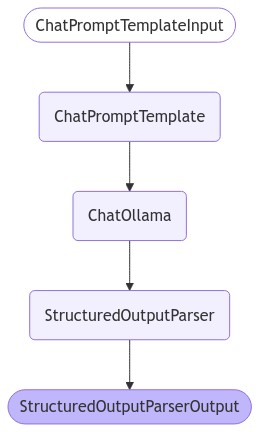

In [5]:
const image = await chain.getGraph().drawMermaidPng();
const arrayBuffer = await image.arrayBuffer();

Deno.jupyter.image(new Uint8Array(arrayBuffer));

## Asking a question

Now we can take our little LLM app for a spin. We can ask it a question and
along with our instructions on how to format the response:

In [9]:
const response = await chain.invoke({
  question: "What is a Deno?",
  format_instructions: parser.getFormatInstructions(),
});

console.log(response);

{
  answer: "Deno is a runtime environment designed for web development. It is built on V8 (the same engine as Google's Chrome) and supports ES modules, async functions, and modern JavaScript features. Deno is known for its modular approach, strong concurrency model, and security-focused design. It is often used for running tests, CLI tools, and small-to-medium web applications due to its performance and simplicity.",
  source: "https://deno.dev"
}


## In the end

I found in my experimentation that the combination of Deno and Jupyter made it
fun and productive to experiment with AI. While there is a little bit of setup,
it really was related to getting an LLM running locally. I could have just as
easily grabbed an
[API token and started interacting](https://js.langchain.com/docs/tutorials/llm_chain)
with Groq, OpenAI, Anthropic or several other public cloud providers.

I already knew how low-friction Deno can be developing, with its batteries
included approach, but I have realized the joy of working with Jupyter Notebooks
now. The incremental approach to exploring something, clearly working out steps
in a developer friendly way with the ability to robustly document your thinking
as you go along is great. In fact I think it has transformed my goto development
experience.